In [1]:
import torch

In [2]:
print("CUDA dispo :", torch.cuda.is_available())
print("GPU :", torch.cuda.get_device_name(0))

CUDA dispo : True
GPU : NVIDIA GeForce RTX 2060


# Ok

In [6]:
import os
import shutil
from pathlib import Path

SRC_DIR = Path("clothing-dataset-small-master")
DEST_DIR = Path("ok")

DEST_DIR.mkdir(exist_ok=True)

splits = ["train", "validation", "test"]
extensions = {".jpg", ".jpeg", ".png"}

counter = 1

for split in splits:
    for category in (SRC_DIR / split).iterdir():
        if category.is_dir():
            for img in category.iterdir():
                if img.suffix.lower() in extensions:
                    new_name = f"ok_{counter:06d}{img.suffix.lower()}"
                    shutil.copy2(img, DEST_DIR / new_name)
                    counter += 1

print(f"Terminé ! {counter - 1} images copiées.")


Terminé ! 3781 images copiées.


# Nok

In [6]:
from pathlib import Path
import json
import shutil

# Répertoires
IMG_DIR = Path("deepfashion/image")
ANNO_DIR = Path("deepfashion/annos")
DEST_DIR = Path("nok")
DEST_DIR.mkdir(exist_ok=True)

# Extensions autorisées
EXTENSIONS = {".jpg", ".jpeg", ".png"}

# Option d'équilibrage avec le dossier OK
OK_DIR = Path("ok")
max_nok = None
if OK_DIR.exists():
    nb_ok = sum(1 for f in OK_DIR.iterdir() if f.suffix.lower() in EXTENSIONS)
    if nb_ok > 0:
        max_nok = nb_ok
        print(f"Dossier 'ok/' détecté : {nb_ok} images. "
              f"On va sélectionner au maximum {max_nok} NOK.")
    else:
        print("Dossier 'ok/' vide, on prendra toutes les images NOK.")
else:
    print("Pas de dossier 'ok/' détecté, on prendra toutes les images NOK.")

# Récupération des images DeepFashion
all_images = sorted(
    [p for p in IMG_DIR.iterdir() if p.is_file() and p.suffix.lower() in EXTENSIONS]
)

counter = 1
for img_path in all_images:

    # NOM DE BASE : image xxxx.jpg -> json xxxx.json
    json_path = ANNO_DIR / (img_path.stem + ".json")

    if not json_path.exists():
        print(f"Pas de JSON pour {img_path.name}, on ignore.")
        continue

    # Chargement JSON
    with json_path.open("r") as f:
        data = json.load(f)

    # DeepFashion utilise parfois plusieurs items : item1, item2...
    # On récupère toutes les clés "itemX"
    item_keys = [k for k in data.keys() if k.startswith("item")]

    # Vérifier s'il existe un viewpoint != 1
    viewpoints = [
        data[k].get("viewpoint", None)
        for k in item_keys
        if isinstance(data[k], dict)
    ]

    # Si AUCUN viewpoint trouvé → ignorer
    if not viewpoints:
        continue

    # On garde l'image si AU MOINS un viewpoint est != 1
    keep = any(v is not None and v != 1 for v in viewpoints)

    if not keep:
        continue

    # Gestion du max
    if max_nok is not None and counter > max_nok:
        break

    # Nouveau nom
    new_name = f"nok_{counter:06d}{img_path.suffix.lower()}"
    dest_path = DEST_DIR / new_name

    shutil.copy2(img_path, dest_path)
    counter += 1

print(f"Terminé. {counter - 1} images NOK copiées dans '{DEST_DIR}'.")


Dossier 'ok/' détecté : 3781 images. On va sélectionner au maximum 3781 NOK.
Terminé. 3781 images NOK copiées dans 'nok'.


# Split Train/Test/Val

In [8]:
from pathlib import Path
import shutil
import random

# Dossiers source
OK_DIR = Path("ok")
NOK_DIR = Path("nok")

# Dossier de sortie
OUT_ROOT = Path("dataset")

# Ratios
RATIOS = {
    "train": 0.70,
    "val": 0.15,
    "test": 0.15,
}

# Extensions valides
EXTENSIONS = {".jpg", ".jpeg", ".png"}

random.seed(42)  # reproductibilité


def list_images(folder: Path):
    return sorted(
        [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in EXTENSIONS]
    )


def stratified_split(files, ratios):
    n = len(files)
    n_train = int(n * ratios["train"])
    n_val = int(n * ratios["val"])
    n_test = n - n_train - n_val

    random.shuffle(files)

    return {
        "train": files[:n_train],
        "val": files[n_train : n_train + n_val],
        "test": files[n_train + n_val :],
    }


# Création du dataset
OUT_ROOT.mkdir(exist_ok=True)

data = {
    "ok": list_images(OK_DIR),
    "nok": list_images(NOK_DIR),
}

print("Nombre d'images :")
for label, files in data.items():
    print(f"  {label}: {len(files)} images")

print("\nCréation des splits...")

for label, files in data.items():
    splits = stratified_split(files, RATIOS)

    for split_name, split_list in splits.items():
        dest_dir = OUT_ROOT / split_name / label
        dest_dir.mkdir(parents=True, exist_ok=True)

        for src in split_list:
            dst = dest_dir / src.name
            shutil.copy2(src, dst)

        print(f"{label} → {split_name}: {len(split_list)} images")

print("\nDataset final créé dans dossier 'dataset/'")

Nombre d'images :
  ok: 3781 images
  nok: 3781 images

Création des splits...
ok → train: 2646 images
ok → val: 567 images
ok → test: 568 images
nok → train: 2646 images
nok → val: 567 images
nok → test: 568 images

Dataset final créé dans dossier 'dataset/'


# Imports fastai + vérification GPU

In [2]:
import fastai
from fastai.vision.all import *
from pathlib import Path

print(f"fastai version : {fastai.__version__}")
print(f"PyTorch version : {torch.__version__}")
print("CUDA dispo :", torch.cuda.is_available())

fastai version : 2.7.17
PyTorch version : 2.4.1
CUDA dispo : True


# Vérification du chemin

In [3]:
path = Path("dataset")
(path/'train').ls(), (path/'val').ls(), (path/'test').ls()

((#2) [Path('dataset/train/nok'),Path('dataset/train/ok')],
 (#2) [Path('dataset/val/nok'),Path('dataset/val/ok')],
 (#2) [Path('dataset/test/nok'),Path('dataset/test/ok')])

# Créer les DataLoaders fastai (train / val)

Classes : ['nok', 'ok']


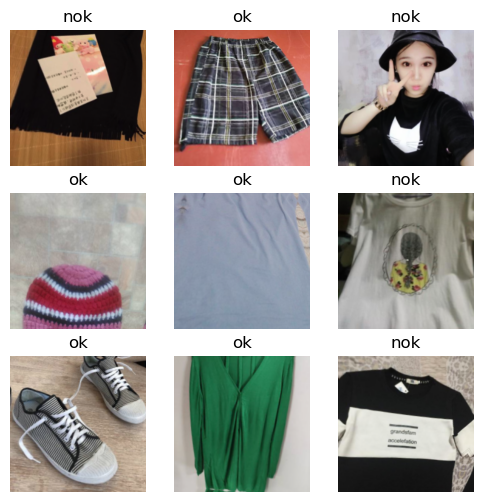

In [4]:
set_seed(42, reproducible=True)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(mult=1.0)
)

dls = dblock.dataloaders(path, bs=64)

dls.show_batch(max_n=9, figsize=(6,6))
print("Classes :", dls.vocab)
